In [22]:
import numpy as np
import matplotlib.pyplot as plt

nside=4096
pixang  = 1  # arcmin
pixang /= 60 # deg
fov = 60 # deg
Rsmin_arcmin = 1
Rsmax_arcmin = 60
nRs = 10

## convolution

In [2]:
def convolve(signal,win,wfunc=None,norm=True,winarr=False):
    def _kernel(scale,sigshape,wfunc=None,norm=True):
        nxr = sigshape[0]//2 ; nyr = sigshape[1]//2
        ax = np.arange(2*nxr) - nxr
        ay = np.arange(2*nyr) - nyr
        x,y  = np.meshgrid(ax,ay,indexing='ij')
        r      = np.sqrt(x**2+y**2)
        if wfunc is not None:
            kernel = wfunc(r/scale)
        else:
            kernel = np.heaviside(scale-r,1.0)
        if norm:
            kernel /= kernel.sum()
        return np.roll(kernel,(-nxr,-nyr),axis=(0,1))
    if not winarr:
        win = _kernel(win,np.shape(signal),wfunc=wfunc,norm=norm)
    return np.real(np.fft.irfftn(np.fft.rfftn(signal)*np.fft.rfftn(win),signal.shape))

## test smoothing on single-pixel at center

(512, 512)


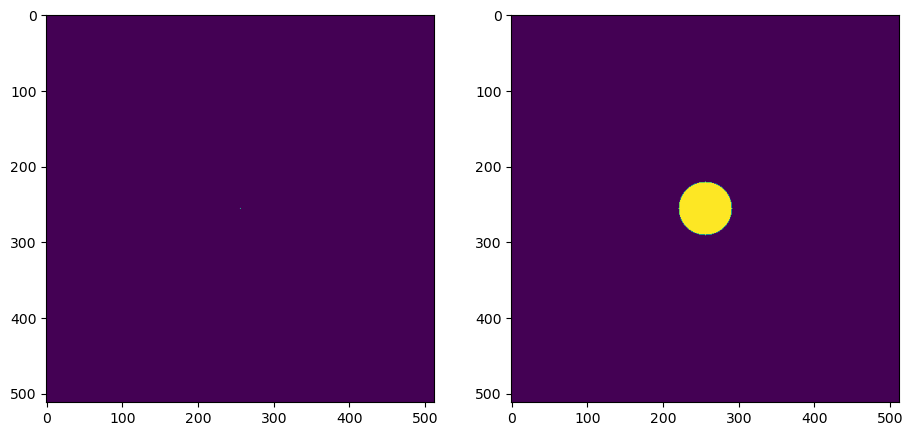

In [3]:
R=35
N=512
def showsmoothing(im,ims):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 8))

    ax1.imshow(im)
    ax2.imshow(ims)
im = np.zeros((N,N),dtype='float')
print(im.shape)
im[N//2,N//2] = 1.0
ims = convolve(im,R)

showsmoothing(im,ims)

def buffscaleflat(im,R,scale=1.0):
    N = im.shape[0] # assume square
    buffer=R+2 ; i1 = buffer ; i2 = N-buffer
    im = im[i1:i2,i1:i2].flatten()
    im = im * scale
    return im

im = buffscaleflat(im,R)
ims = buffscaleflat(ims,R,scale=np.sqrt(np.pi)*R)

## run 10 random samples and show histograms, with and without smoothing, for images with values scaled by $(\pi{R}^2)^{1/2}$

In [4]:
def comparepdfs_wnoise(im,R,i):
    ims = convolve(im,R) - im.mean()
    im -= im.mean()

    im = buffscaleflat(im,R)
    ims = buffscaleflat(ims,R,scale=np.sqrt(np.pi)*R)

    c = ['r','g','b','c','m','y'][i%6]
    lh = None
    lhs = None
    if i == 0:
        lh = r'$R='+str(0)+r'$'
        lhs = r'$R='+str(35)+r'$'
    h = plt.hist(im,bins=100,fill=None,histtype='step',color='k',label=lh,density=True)
    hs = plt.hist(ims,bins=100,fill=None,histtype='step',color=c,density=True)
    plt.gca().set_yscale('log')
    ax = plt.gca()
    return ax

def runsample(i,N,R):
    im = np.reshape(np.random.normal(0, 1, N**2),(N,N))
    ax = comparepdfs_wnoise(im,R,i)

def allsamples(N,R,nsample):
    for i in range(nsample): runsample(i,N,R)
    plt.legend()
    t=plt.gca().set_title(str(N)+' x '+str(N)+'     '+r'$R_s='+str(R)+r'$')

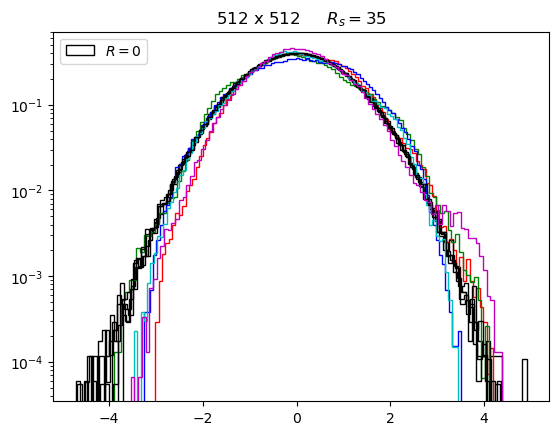

In [5]:
allsamples(512,35,5)

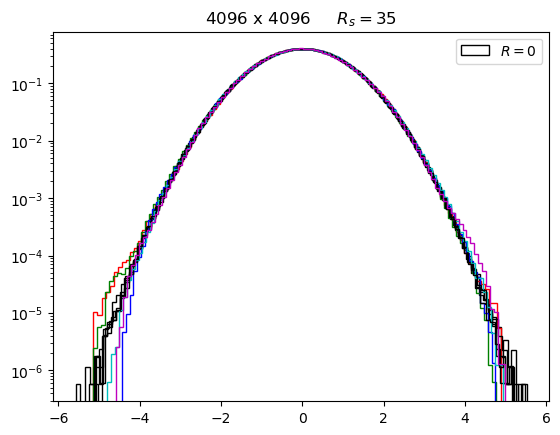

In [6]:
allsamples(4096,35,5)

In [15]:
datapath = '/global/cfs/cdirs/mp107d/exgal/users/malvarez/websky/cita/'
import healpy as hp
import os
filter_healpix_maps = False
if not os.path.isfile(datapath+'tl_full.fits'): filter_healpix_maps = True

In [16]:
if filter_healpix_maps:
    tplfa = datapath+'lensed_alm.fits'
    tpulfa = datapath+'unlensed_alm.fits'
    pkszf = datapath+'4e3_2048_50_50_ksz.fits'

    tpl_full = hp.alm2map(hp.read_alm(tplfa),nside=nside)
    tpul_full = hp.alm2map(hp.read_alm(tpulfa),nside=nside)
    pksz_full = hp.ud_grade(hp.read_map(pkszf),nside)

    cl_tpl = hp.anafast(tpl_full,iter=0)
    cl_pksz = hp.anafast(pksz_full,iter=0)

    W = cl_pksz / (cl_pksz + cl_tpl)
    ellW = np.arange(len(W))

    def ell_filter(m,lmin,lmax,nside):
        ell = np.arange(lmax+1)
        fl = np.interp(ell,ellW,W)
        fl[ell<lmin] = 0
        fl[ell>lmax] = 0
        return hp.alm2map(hp.almxfl(hp.map2alm(m,iter=0),fl),nside=nside)

    lmin = 3000
    lmax = 5000

    tl_full  = tpl_full  + pksz_full
    tul_full = tpul_full + pksz_full

    tl_hpass   = ell_filter(tl_full,lmin,lmax,nside)
    tpl_hpass  = ell_filter(tpl_full,lmin,lmax,nside)
    tpul_hpass = ell_filter(tpul_full,lmin,lmax,nside)
    tul_hpass  = ell_filter(tul_full,lmin,lmax,nside)
    pksz_hpass = ell_filter(pksz_full,lmin,lmax,nside)

    hp.write_map(datapath+"tl_full.fits",   tl_full , dtype=np.float32)
    hp.write_map(datapath+"tpl_full.fits",  tpl_full, dtype=np.float32)
    hp.write_map(datapath+"tpul_full.fits", tpul_full,dtype=np.float32)
    hp.write_map(datapath+"tul_full.fits",  tul_full, dtype=np.float32)
    hp.write_map(datapath+"pksz_full.fits", pksz_full,dtype=np.float32)

    hp.write_map(datapath+"tl_hpass.fits", tl_hpass,    dtype=np.float32)
    hp.write_map(datapath+"tpl_hpass.fits", tpl_hpass,  dtype=np.float32)
    hp.write_map(datapath+"tpul_hpass.fits", tpul_hpass,dtype=np.float32)
    hp.write_map(datapath+"tul_hpass.fits", tul_hpass,  dtype=np.float32)
    hp.write_map(datapath+"pksz_hpass.fits", pksz_hpass,dtype=np.float32)
else:
    tl_full   = hp.read_map(datapath+"tl_full.fits")
    tpl_full  = hp.read_map(datapath+"tpl_full.fits")
    tpul_full = hp.read_map(datapath+"tpul_full.fits")
    tul_full  = hp.read_map(datapath+"tul_full.fits")
    pksz_full = hp.read_map(datapath+"pksz_full.fits")

    tl_hpass   = hp.read_map(datapath+"tl_hpass.fits")
    tpl_hpass  = hp.read_map(datapath+"tpl_hpass.fits")
    tpul_hpass = hp.read_map(datapath+"tpul_hpass.fits")
    tul_hpass  = hp.read_map(datapath+"tul_hpass.fits")
    pksz_hpass = hp.read_map(datapath+"pksz_hpass.fits")

In [17]:
N = fov // pixang
ra=[-fov/2,fov/2]
tpl = hp.cartview(tpl_hpass,return_projected_map=True,xsize=N,ysize=N,lonra=ra,latra=ra) ; plt.close() 
tpul = hp.cartview(tpul_hpass,return_projected_map=True,xsize=N,ysize=N,lonra=ra,latra=ra); plt.close()
tl = hp.cartview(tl_hpass,return_projected_map=True,xsize=N,ysize=N,lonra=ra,latra=ra) ; plt.close() 
tul = hp.cartview(tul_hpass,return_projected_map=True,xsize=N,ysize=N,lonra=ra,latra=ra) ; plt.close() 
pksz = hp.cartview(pksz_hpass,return_projected_map=True,xsize=N,ysize=N,lonra=ra,latra=ra); plt.close()

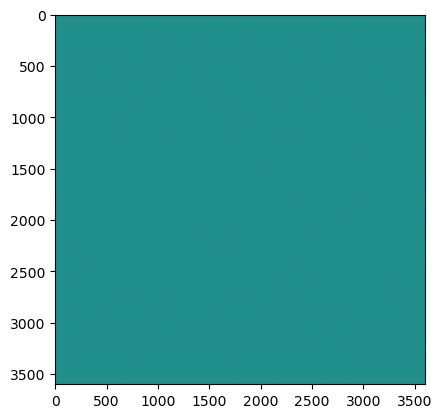

In [18]:
plt.imshow(pksz)

In [25]:
from scipy.stats import skew
from scipy.stats import kurtosis as kurt
from statsmodels.stats.stattools import jarque_bera

def scalecalc(im,R,dR,i,label=None,showpdf=False):

    R1 = R
    R2 = R+dR

    im1 = convolve(im,R1) - im.mean()
    im2 = convolve(im,R2) - im.mean()

    im1 = buffscaleflat(im1,R2)
    im2 = buffscaleflat(im2,R2)
    
    im1 *= 1./np.sqrt(im1.var())
    im2 *= 1./np.sqrt(im2.var())

    ims = im1 - im2

    if showpdf:
        c = ['r','g','b','c','m','y'][i%6]
        h = plt.hist(ims,bins=100,fill=None,histtype='step',color=c,label=label,density=True)
        plt.gca().set_yscale('log')

    lstd  = ims.std()
    ljb   = jarque_bera(ims)
    lskew = ljb[2]
    lkurt = ljb[3] - 3 # turn kurtosis into excess kurtosis
    return lstd, ljb[0], ljb[1], lskew, lkurt

In [26]:
def scalecalcs(Rs_arcmin):
    Rs_pix     = int(Rs_arcmin / 60 / pixang) # pixels
    tl_stats   = scalecalc(tl,Rs_pix,2,0,label='unlensed primary')
    tpl_stats  = scalecalc(tpl,Rs_pix,2,1,label='lensed primary')
    tul_stats  = scalecalc(tul,Rs_pix,2,0,label='unlensed primary + p-kSZ')
    tpul_stats = scalecalc(tpul,Rs_pix,2,3,label='unlensed primary + p-kSZ')
    pksz_stats = scalecalc(pksz,Rs_pix,2,2,label='p-kSZ')
    return tl_stats, tpl_stats, tul_stats, tpul_stats, pksz_stats

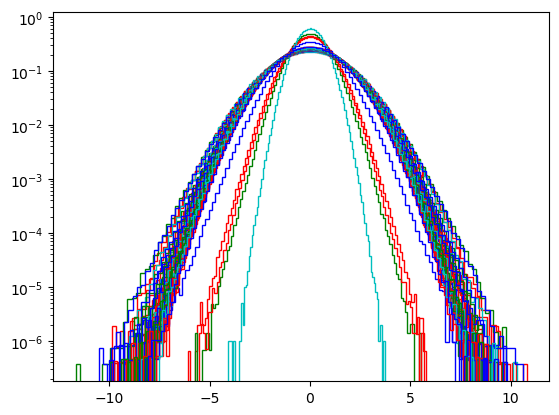

In [24]:
i=0
tl_statsa   = []
tpl_statsa  = []
tul_statsa  = []
tpul_statsa = [] 
pksz_statsa = []
Rsmooth_arcmina = np.linspace(Rsmin_arcmin,Rsmax_arcmin,nRs)
i=1
for Rsmooth_arcmin in Rsmooth_arcmina:
    print(i,nRs,end='\r', flush=True)
    i += 1
    tl_stats, tpl_stats, tul_stats, tpul_stats, pksz_stats = scalecalcs(Rsmooth_arcmin)
    tl_statsa.append(tl_stats)
    tpl_statsa.append(tpl_stats)
    tul_statsa.append(tul_stats)
    tpul_statsa.append(tpul_stats)
    pksz_statsa.append(pksz_stats)

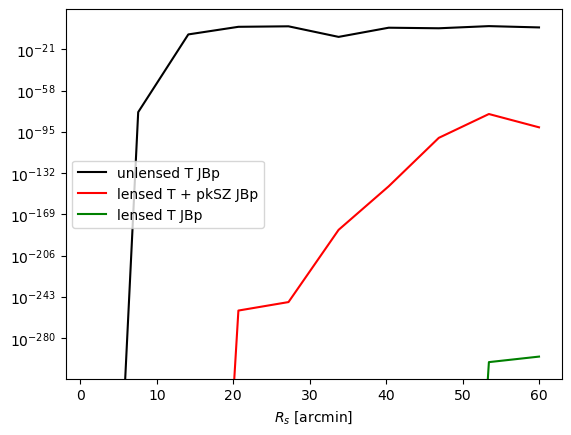

In [28]:
tl_statsa = np.asarray(tl_statsa)
tpl_statsa = np.asarray(tpl_statsa)
tul_statsa = np.asarray(tul_statsa)
tpul_statsa = np.asarray(tpul_statsa)
pksz_statsa = np.asarray(pksz_statsa)
plt.plot(Rsmooth_arcmina,tpul_statsa[:,2],c='k',label = 'unlensed T JBp')
plt.plot(Rsmooth_arcmina,tl_statsa[:,2],  c='r',label = 'lensed T + pkSZ JBp')
plt.plot(Rsmooth_arcmina,tpl_statsa[:,2], c='g',label = 'lensed T JBp')
#plt.plot(Rsmooth_arcmina,tul_statsa[:,2] c='b',label = 'unlensed T + pkSZ JB')
plt.gca().set_yscale('log')
#plt.plot(Rsmooth_arcmina,pksz_statsa[:,4],label='pkSZ JB')
plt.gca().set_xlabel(r'$R_s$ [arcmin]')
plt.legend()

In [95]:
showpdf(tul,Rs_pix,2,0)
p=plt.gca().set_title(r'unlensed primary + pkSZ   $R_s = $'+str(int(pixang*60))+' arcmin')

NameError: name 'showpdf' is not defined